# q-1-4
###### Visualise training data on a 2-dimensional plot taking satisfaction_level on x-axis and last_evaluation on y-axis

In [1]:
import numpy as np
from numpy import log2 as log
import pandas as pd
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
eps = np.finfo(float).eps

from pylab import *
import matplotlib
import matplotlib.pyplot as plt

#### load data

In [2]:
df = pd.read_csv('train.csv')

#### get class label into Y and drop it from it from df and assign to X

In [3]:
Y = df.left
X = df.drop(['left'], axis=1)

#### perform one hot encoding 

In [4]:
Z = pd.concat([X,pd.get_dummies(X['sales'],prefix='sales')],axis=1)
Z = pd.concat([Z,pd.get_dummies(Z['salary'],prefix='salary')],axis=1)
Z = Z.drop(['sales','salary'],axis=1)

#### split data into training(80%) and testing(20%)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(Z, Y,test_size=0.2)
df1 = pd.concat([X_train, Y_train],axis=1)

#### plotting satisfaction_level vs last_evaluation using scatter plot

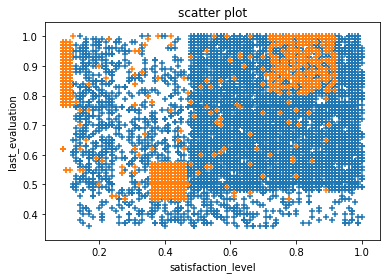

In [6]:
xtr0=df1[df1['left']==0]
xtr1=df1[df1['left']==1]

figure()
scatter(xtr0['satisfaction_level'],xtr0['last_evaluation'],marker='+')
scatter(xtr1['satisfaction_level'],xtr1['last_evaluation'],marker='+')

xlabel('satisfaction_level')
ylabel('last_evaluation')
title('scatter plot')
show()

#### Calculate entropy of class label

In [7]:
def class_entropy(df):
    class_label = df.keys()[-1]
    class_entropy = 0
    values = df[class_label].unique()
    for val in values:
        q = float(df[class_label].value_counts()[val])/len(df[class_label])
        class_entropy += -q*log(q)
    return class_entropy

#### calculate entropy of a feature

In [8]:
def feature_entropy(df, feature):
    class_label = df.keys()[-1]
    target_variables = df[class_label].unique()
    variables = df[feature].unique()
    entropy = 0
    for var in variables:
        ent = 0
        for t in target_variables:
            n = len(df[feature][df[feature]==var][df[class_label]==t])
            d = len(df[feature][df[feature]==var])
            q = n/(d+eps)
            ent += -q*log(q+eps)
        q2 = float(d)/len(df)
        entropy += -q2*ent
    return abs(entropy)

#### calculate the split point for numerical feature

In [9]:

def split_num_feature(data,cl_label,feature):
    
    max_ig = 0
    max_split = None
    pair = pd.concat([data,cl_label],axis=1)
    pair = pair.sort_values(by=feature).reset_index()
    found = set()
    for i in xrange(len(data)-1):
        if pair['left'][i]!=pair['left'][i+1] and (float(pair[feature][i] + pair[feature][i+1])/2) not in found:
            found.add(float(pair[feature][i] + pair[feature][i+1])/2)
            ig = compute_IG(pair,float(pair[feature][i] + pair[feature][i+1])/2, feature)
            if ig > max_ig:
                max_ig = ig
                max_split = float(pair[feature][i] + pair[feature][i+1])/2
    return max_split


#### calculate IG of all features and select feature with maximum gain

In [10]:
numerical_attributes=['number_project','last_evaluation', 'satisfaction_level','average_montly_hours','time_spend_company']
split_values={}

def feature_to_select(df):
    num_attr = [i for i in df.columns if i in numerical_attributes]
    for at in num_attr:
        split = split_num_feature(df[at],df['left'],at)
        split_values[at]=split

    gain = []
    for key in df.keys()[:-1]:
        gain.append(class_entropy(df)-feature_entropy(df,key))
    return df.keys()[:-1][np.argmax(gain)]

#### function to split data

In [11]:
def subtable(df,node,value):
    return df[df[node]==value].reset_index(drop=True)

#### helper function to calculate gain of numerical features

In [12]:
def compute_IG(df,val,feature):
    cl_entropy = class_entropy(df)
    l = df[df[feature]<val].reset_index(drop=True)
    r = df[df[feature]>=val].reset_index(drop=True)
    l_entropy = class_entropy(l)
    r_entropy = class_entropy(r)
    return cl_entropy - ( (float(len(l))/(len(df)+eps)*l_entropy) + (float(len(r))/(len(df)+eps)*r_entropy) )  

#### change dataframe from numerical to 0 and 1 according to split point

#### calculate the split point for all numerical features and get split values for all in a dictionary

#### preprocess data to perform prediction

#### node of decision tree

In [13]:
class Node:
    def __init__(self,feature,positive=0,negative=0):
        self.feature=feature
        self.split_pos=0
        self.positive=positive
        self.negative=negative
        self.left=None
        self.right=None

#### function that generates the tree

In [14]:
def build_Tree(df):
    if len(df.columns)==1:
        return None
    
    split_node = feature_to_select(df)
    print split_values
    root = Node(split_node)
    if split_node in numerical_attributes:
        split_point = split_values[root.feature]
        root.split_pos = split_point
        
        root.positive=len(df[df['left']>=split_point]['left'])
        root.negative=len(df[df['left']<split_point]['left'])
        
        subtable_left = df[df[split_node]<split_point].reset_index(drop=True)
        subtable_right = df[df[split_node]>=split_point].reset_index(drop=True)
    
    else:
        root.positive=len(df[df['left']==1]['left'])
        root.negative=len(df[df['left']==0]['left'])
        
        subtable_left = subtable(df,split_node,0)
        subtable_right = subtable(df,split_node,1)
    
    subtable_left = subtable_left.drop(split_node,axis=1)
    subtable_right = subtable_right.drop(split_node,axis=1)
    
    clValue_left,counts_left = np.unique(subtable_left['left'],return_counts=True)
    clValue_right,counts_right = np.unique(subtable_right['left'],return_counts=True)
    
    if len(counts_left)>1:
        root.left=build_Tree(subtable_left)
    
    if len(counts_right)>1:
        root.right=build_Tree(subtable_right)
        
    return root

In [15]:
root=build_Tree(df1)

{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 287.0, 'time_spend_company': 3.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 125.5, 'time_spend_company': 5.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 

{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 

{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 162.0, 'time_spend_company': 3.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 277.0, 'time_spend_company': 4.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.575, 'average_montly_hours': 277.0, 'time_spend_company': 4.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 

{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, 'average_montly_hours': 242.5, 'time_spend_company': 6.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.45, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.0, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, 'average_montly_hours': 242.5, 'time_spend_company': 5.5, 'number_project': 2.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.77, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_

{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_

{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_

{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_montly_hours': 290.5, 'time_spend_company': 5.0, 'number_project': 6.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.7, 'average_

{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 4.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 4.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 4.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 4.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 4.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 4.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 4.0}
{'satisfaction_level': 0.47, 'last_evaluation': 

{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 5.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 5.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 5.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 5.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 5.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 5.0}
{'satisfaction_level': 0.47, 'last_evaluation': 0.995, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 5.0}
{'satisfaction_level': 0.47, 'last_evaluation': 

{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 6.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, '

{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, 'average_montly_hours': 216.5, 'time_spend_company': 5.0, 'number_project': 3.5}
{'satisfaction_level': 0.47, 'last_evaluation': 0.82, '

#### prediction function

In [16]:
def rec_predict(df,root,prediction):
    if root==None:
        return None

    if root.feature in numerical_attributes:
        try:
            if root.right==None and root.left==None:
                prediction.append(1 if root.positive>root.negative else 0)
                return

            if root.right==None and df[root.feature]>=root.split_pos:
                prediction.append(1 if root.positive>root.negative else 0)
                return

            if root.left==None and df[root.feature]<root.split_pos:
                prediction.append(1 if root.positive>root.negative else 0)
                return

            if df[root.feature]<root.split_pos:
                rec_predict(df,root.left,prediction)
            else:
                rec_predict(df,root.right,prediction)
        except KeyError:
            if root.left==None:
                prediction.append(1 if root.positive>root.negative else 0)
                return
            rec_predict(df,root.left,prediction)
    else:
        try:
            if root.right==None and root.left==None:
                prediction.append(1 if root.positive>root.negative else 0)
                return

            if root.right==None and df[root.feature]==1:
                prediction.append(1 if root.positive>root.negative else 0)
                return

            if root.left==None and df[root.feature]==0:
                prediction.append(1 if root.positive>root.negative else 0)
                return

            if df[root.feature]==0:
                rec_predict(df,root.left,prediction)
            else:
                rec_predict(df,root.right,prediction)
        except KeyError:
            if root.left==None:
                prediction.append(1 if root.positive>root.negative else 0)
                return
            rec_predict(df,root.left,prediction)
            
def predict(df,root,prediction):
    for col,row in df.iterrows():
        rec_predict(row,root,prediction)

#### perform prediction with our model

In [17]:
pd.options.mode.chained_assignment = None
X1_test = X_test.copy(deep=True)

prediction = []
# preprocess(X_test,split_values)
predict(X_test,root,prediction)
print confusion_matrix(Y_test,prediction)
print classification_report(Y_test,prediction)
print accuracy_score(Y_test,prediction)

[[1659   42]
 [  50  497]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1701
           1       0.92      0.91      0.92       547

   micro avg       0.96      0.96      0.96      2248
   macro avg       0.95      0.94      0.94      2248
weighted avg       0.96      0.96      0.96      2248

0.9590747330960854


#### perform prediciton with inbuilt model

In [18]:
model = tree.DecisionTreeClassifier()

model.fit(X_train, Y_train)
Y_predict = model.predict(X1_test)
print confusion_matrix(Y_test,Y_predict)
print classification_report(Y_test,Y_predict)
print accuracy_score(Y_test,Y_predict)

[[1658   43]
 [  26  521]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1701
           1       0.92      0.95      0.94       547

   micro avg       0.97      0.97      0.97      2248
   macro avg       0.95      0.96      0.96      2248
weighted avg       0.97      0.97      0.97      2248

0.969306049822064


#### Testing from file

In [19]:
ot = []
test_rows=pd.read_csv('../input_data/sample_test.csv')
test_rows1 = pd.concat([test_rows,pd.get_dummies(test_rows['sales'],prefix='sales')],axis=1)
test_rows1 = pd.concat([test_rows1,pd.get_dummies(test_rows1['salary'],prefix='salary')],axis=1)
test_rows1 = test_rows1.drop(['sales','salary'],axis=1)
# preprocess(test_rows1,split_values)
predict(test_rows1,root,ot)
print "ANS ", len(ot)
print ot

ANS  2
[0, 1]


#### Observations
Plotting features over 2D can help get an idea of their distributions and where the decision boundary might lie

In this case satisfaction_level takes values around 0.47 and last_evaluation takes values around 0.575, 0.45, 0.77, 0.8, 0.9 depending on which node is being considered in splitting and we can see in the plot that these points are the one where decision boundary might lie